CS412 Homework 1 - Huseyin Samed Dagci 30996

Import the necesarry libraries

```python
numpy, pandas, matplotlib, seaborn, sklearn, tensorflow
```

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Install tensorflow package

from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc


In [5]:
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Normalize pixel values (0-255 → 0-1)
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Split training data into 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Print dataset shapes
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 6s 1us/step
Training set shape: (48000, 28, 28)
Validation set shape: (12000, 28, 28)
Test set shape: (10000, 28, 28)


Class Distribution in Training Set: {0: 4748, 1: 5420, 2: 4784, 3: 4912, 4: 4666, 5: 4317, 6: 4741, 7: 4966, 8: 4691, 9: 4755}
Mean pixel value: 0.1307
Standard deviation: 0.3082


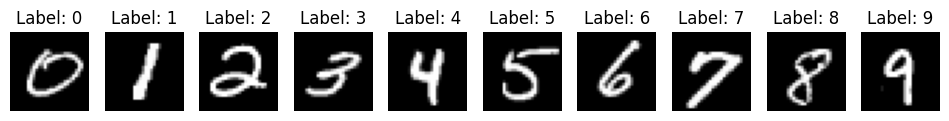

In [6]:
# Class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Class Distribution in Training Set:", dict(zip(unique, counts)))

# Compute statistics
print(f"Mean pixel value: {np.mean(X_train):.4f}")
print(f"Standard deviation: {np.std(X_train):.4f}")

# Display sample images
fig, axes = plt.subplots(1, 10, figsize=(12, 4))
for i in range(10):
    idx = np.where(y_train == i)[0][0]  # Get first occurrence of each digit
    axes[i].imshow(X_train[idx], cmap='gray')
    axes[i].set_title(f"Label: {i}")
    axes[i].axis("off")
plt.show()


KNN Classifier

k=1, Validation Accuracy=0.9741
k=3, Validation Accuracy=0.9727
k=5, Validation Accuracy=0.9715
k=7, Validation Accuracy=0.9696
k=9, Validation Accuracy=0.9673


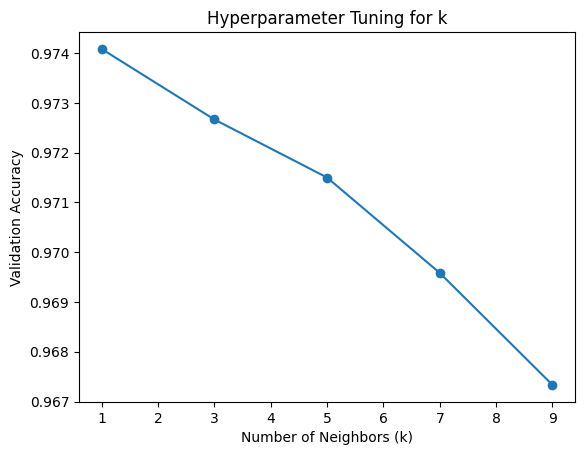

In [16]:
k_values = [1, 3, 5, 7, 9]
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train.reshape(len(X_train), -1), y_train)
    
    y_pred_val = knn.predict(X_val.reshape(len(X_val), -1))
    acc = accuracy_score(y_val, y_pred_val)
    
    accuracies.append(acc)
    print(f"k={k}, Validation Accuracy={acc:.4f}")

# Plot accuracy vs. k
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Validation Accuracy')
plt.title('Hyperparameter Tuning for k')
plt.show()


In [8]:
best_k = k_values[np.argmax(accuracies)]
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(np.vstack((X_train, X_val)).reshape(len(X_train) + len(X_val), -1), np.hstack((y_train, y_val)))

y_pred_test = knn_final.predict(X_test.reshape(len(X_test), -1))

print("Final k-NN Evaluation on Test Set:")
print(classification_report(y_test, y_pred_test))


Final k-NN Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.95      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.98      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



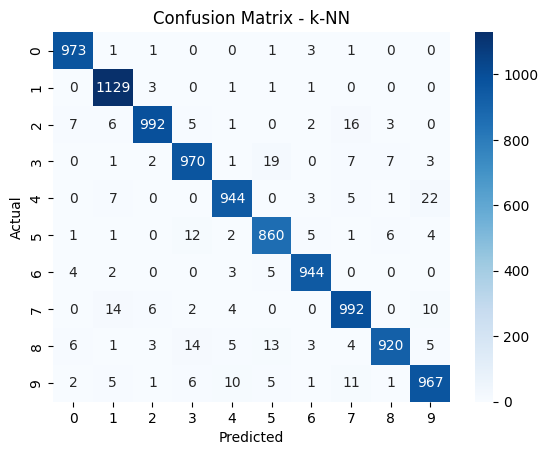

In [9]:
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - k-NN")
plt.show()


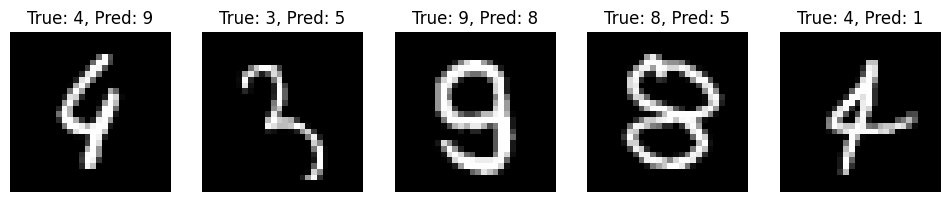

In [10]:
misclassified = np.where(y_test != y_pred_test)[0]
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i, ax in enumerate(axes):
    idx = misclassified[i]
    ax.imshow(X_test[idx], cmap="gray")
    ax.set_title(f"True: {y_test[idx]}, Pred: {y_pred_test[idx]}")
    ax.axis("off")

plt.show()


Decision Tree Classifier


In [21]:
best_acc = 0
best_params = None

for depth in [2, 5, 10]:
    for split in [2, 5]:
        tree = DecisionTreeClassifier(max_depth=depth, min_samples_split=split)
        tree.fit(X_train.reshape(len(X_train), -1), y_train)
        
        y_pred_val = tree.predict(X_val.reshape(len(X_val), -1))
        acc = accuracy_score(y_val, y_pred_val)
        
        if acc > best_acc:
            best_acc = acc
            best_params = (depth, split)

print(f"Best Parameters: max_depth={best_params[0]}, min_samples_split={best_params[1]} with {round(best_acc, 4)} accuracy")


Best Parameters: max_depth=10, min_samples_split=2 with 0.8582 accuracy


In [18]:
tree_final = DecisionTreeClassifier(max_depth=best_params[0], min_samples_split=best_params[1])
tree_final.fit(np.vstack((X_train, X_val)).reshape(len(X_train) + len(X_val), -1), np.hstack((y_train, y_val)))

y_pred_tree = tree_final.predict(X_test.reshape(len(X_test), -1))
print("Decision Tree Evaluation on Test Set:")
print(classification_report(y_test, y_pred_tree))


Decision Tree Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       980
           1       0.95      0.96      0.95      1135
           2       0.86      0.84      0.85      1032
           3       0.82      0.84      0.83      1010
           4       0.86      0.85      0.86       982
           5       0.84      0.80      0.82       892
           6       0.91      0.87      0.89       958
           7       0.90      0.88      0.89      1028
           8       0.79      0.82      0.81       974
           9       0.81      0.86      0.83      1009

    accuracy                           0.87     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.87      0.87     10000

